[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/pixeltable/pixeltable/blob/master/docs/release/tutorials/object-detection-in-videos.ipynb)&nbsp;&nbsp;
[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pixeltable/pixeltable/blob/master/docs/release/tutorials/object-detection-in-videos.ipynb)

# Object Detection in Videos

In this tutorial, we'll demonstrate how to use Pixeltable to do frame-by-frame object detection, made simple through Pixeltable's video-related functionality:
* automatic frame extraction
* running complex functions against frames (in this case, the YOLOX object detection models)
* reassembling frames back into videos
We'll be working with a single video file from Pixeltable's test data repository.

This tutorial assumes you've worked through the [Pixeltable Basics](https://pixeltable.github.io/pixeltable/tutorials/pixeltable-basics/) tutorial; if you haven't, it's probably a good idea to do so now.

## Creating a tutorial directory and table

First, let's make sure the packages we need for this tutorial are installed: Pixeltable itself, and the YOLOX object detection library.

In [ ]:
%pip install -q pixeltable git+https://github.com/Megvii-BaseDetection/YOLOX@ac58e0a

As we saw in the Pixeltable Basics tutorial, all data in Pixeltable is stored in tables, which in turn reside in directories. We'll begin by creating a `video_tutorial` directory.

In [1]:
import pixeltable as pxt

pxt.create_dir('video_tutorial', ignore_errors=True)

Connected to Pixeltable database at: postgresql://postgres:@/pixeltable?host=/Users/orm/.pixeltable/pgdata


We create a table for our videos, with a single column.

In [2]:
# Drop the tables if they exist, in case they were created by a previous
# run of the tutorial
pxt.drop_table('video_tutorial.frames', ignore_errors=True)
pxt.drop_table('video_tutorial.videos', ignore_errors=True)

# Create the `video_tutorial.videos` table
videos_table = pxt.create_table('video_tutorial.videos', {'video': pxt.VideoType()})

Created table `videos`.


In order to interact with the frames, we take advantage of Pixeltable's component view concept: we create a "view" of our video table that contains one row for each frame of each video in the table. Pixeltable provides the built-in `FrameIterator` class for this.

In [3]:
from pixeltable.iterators import FrameIterator

frames_view = pxt.create_view(
    'video_tutorial.frames',
    videos_table,
    # `fps` determines the frame rate; a value of `0`
    # indicates the native frame rate of the video.
    iterator=FrameIterator.create(video=videos_table.video, fps=0)
)

Created view `frames` with 0 rows, 0 exceptions.


You'll see that neither the `videos` table nor the `frames` view has any actual data yet, because we haven't yet added any videos to the table. However, the `frames` view is now configured to automatically track the `videos` table as new data shows up.

The new view is automatically configured with six columns:
- `pos` - a system column that is part of every component view
- `video` - the column inherited from our base table (all base table columns are visible in any of its views)
- `frame_idx`, `pos_msec`, `pos_frame`, `frame` - these four columns are created by the `FrameIterator` class.

Let's have a look at the new view:

In [4]:
frames_view

Column Name,Type,Computed With
pos,int,
frame_idx,int,
pos_msec,float,
pos_frame,float,
frame,image,
video,video,


We'll now insert a single row into the videos table, containing a video of a busy intersection in Bangkok.

In [206]:
string_test = pxt.create_table('string_test', {'string_col':pxt.StringType()})

Created table `string_test`.


In [207]:
string_test.insert(string_col='hi')

Inserting rows into `string_test`: 1 rows [00:00, 305.44 rows/s]
Inserted 1 row with 0 errors.


UpdateStatus(num_rows=1, num_computed_values=0, num_excs=0, updated_cols=[], cols_with_excs=[])

In [222]:
string_test.insert(string_col=

Inserting rows into `string_test`: 1 rows [00:00, 559.61 rows/s]
Inserted 1 row with 0 errors.


UpdateStatus(num_rows=1, num_computed_values=0, num_excs=0, updated_cols=[], cols_with_excs=[])

In [213]:
import string

In [220]:
mystr = "hi\n<br>again"

In [219]:
#str(mystr) == mystr

In [225]:
print("hi<b>again</b>")

hi<b>again</b>


In [226]:
import pandas as pd

In [230]:
x = pd.DataFrame({'hi':['hello<b>world</b>']})

In [231]:
x

,hi
0,hello<b>world</b>


In [235]:
import IPython.display

In [240]:
x.to_html(escape=True)

'<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th></th>\n      <th>hi</th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr>\n      <th>0</th>\n      <td>hello&lt;b&gt;world&lt;/b&gt;</td>\n    </tr>\n  </tbody>\n</table>'

In [239]:
IPython.display.HTML()

,hi
0,hello<b>world</b>


In [223]:
string_test.show()

string_col
hi
higain
hi again
hiagain


In [113]:
json_test = pxt.get_table('json_test')

In [114]:
json_test.insert(json_col=[1,2,3])

Inserting rows into `json_test`: 1 rows [00:00, 269.11 rows/s]
Inserted 1 row with 0 errors.


UpdateStatus(num_rows=1, num_computed_values=0, num_excs=0, updated_cols=[], cols_with_excs=[])

In [115]:
json_test.show()

json_col
"[1, 2, 3]"


In [5]:
'/Users/orm/repos/pixeltable/tests/data/videos/bangkok_half_res.mp4'

'/Users/orm/repos/pixeltable/tests/data/videos/bangkok_half_res.mp4'

In [6]:
#videos_table.insert([{'video': 'https://raw.github.com/pixeltable/pixeltable/master/docs/source/data/bangkok.mp4'}])

In [7]:
videos_table.insert([{'video': '/Users/orm/repos/pixeltable/tests/data/videos/bangkok_half_res.mp4'}])

Inserting rows into `videos`: 1 rows [00:00, 649.88 rows/s]
Inserting rows into `frames`: 462 rows [00:00, 13249.97 rows/s]
Inserted 463 rows with 0 errors.


UpdateStatus(num_rows=463, num_computed_values=0, num_excs=0, updated_cols=[], cols_with_excs=[])

Notice that both the `videos` table and `frames` view were automatically updated, expanding the single video into 462 rows in the view. Let's have a look at `videos` first.

video
""

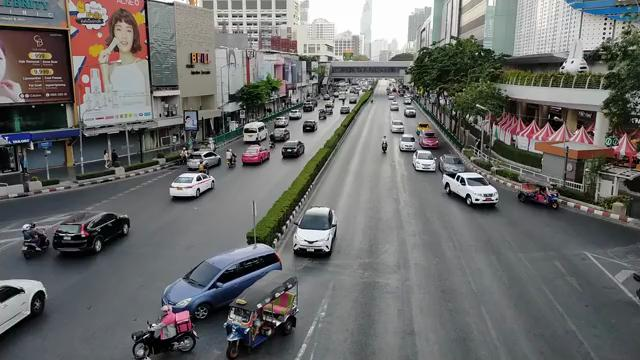

In [8]:
videos_table.show()

Now let's peek at the first five rows of `frames`:

pos,frame,width,height
0,,640,360
1,,640,360
2,,640,360
3,,640,360
4,,640,360

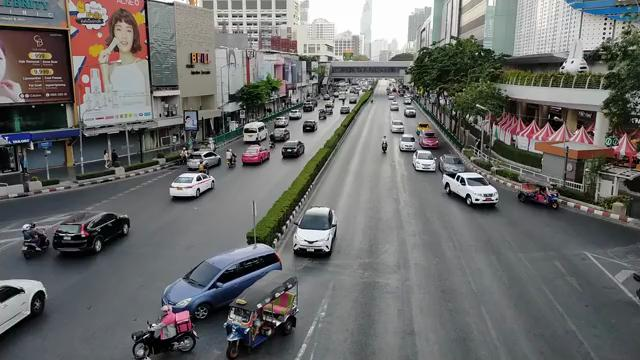
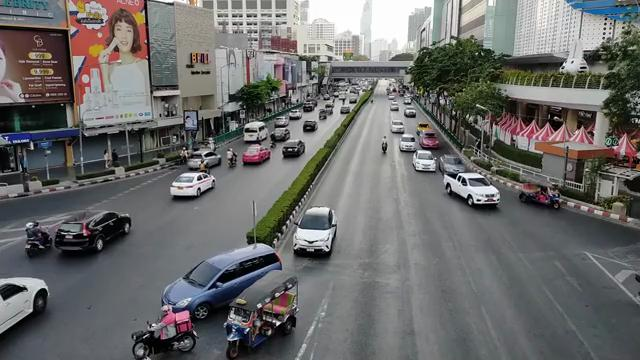
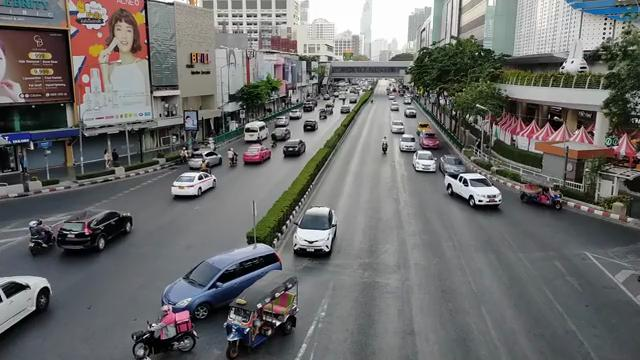
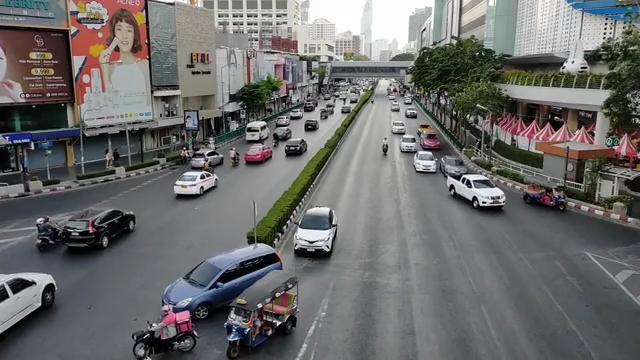
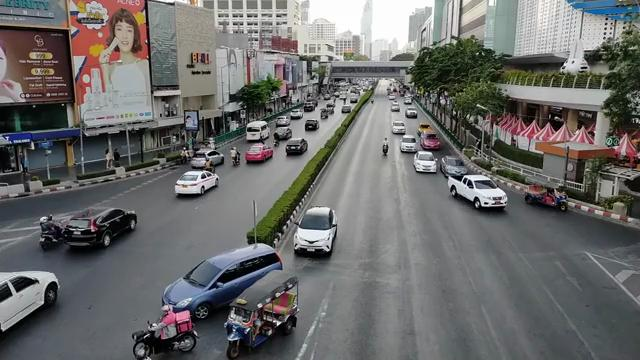

In [9]:
frames_view.select(frames_view.pos, frames_view.frame, frames_view.frame.width, frames_view.frame.height).show(5)

One advantage of using Pixeltable's component view mechanism is that Pixeltable does not physically store the frames. Instead, Pixeltable re-extracts the frames on retrieval using the frame index, which can be done very efficiently and avoids any storage overhead (which can be quite substantial for video frames).

## Object Detection with Pixeltable

Now let's apply an object detection model to our frames. Pixeltable includes built-in support for a number of models; we're going to use the YOLOX family of models, which are lightweight models with solid performance. We first import the `yolox` Pixeltable function.

In [10]:
from pixeltable.ext.functions.yolox import yolox

Pixeltable functions operate on columns and expressions using standard Python function call syntax. Here's an example that shows how we might experiment with applying one of the YOLOX models to the first few frames in our video, using Pixeltable's powerful `select` comprehension.

In [105]:
np.array2string(np.array(1.344555345), precision=3, threshold=16)

'1.345'

In [169]:
def pretty_print_json(data, indent=4, level=0):
    def indent_str(level):
        return ' ' * (level * indent)

    if isinstance(data, dict):
        items = []
        for key, value in data.items():
            items.append(f'\n{indent_str(level + 1)}"{key}": {pretty_print_json(value, indent, level + 1)}')
        return '{' + ','.join(items) + f'\n{indent_str(level)}}}'
    
    elif isinstance(data, list):
        items = [f'\n{indent_str(level + 1)}{pretty_print_json(item, indent, level + 1)}' for item in data]
        return '[' + ','.join(items) + f'\n{indent_str(level)}]'
    
    elif isinstance(data, str):
        return f'"{data}"'
    
    else:
        return str(data)

# Sample JSON data
data = {
    "name": "John Doe",
    "age": 30,
    "city": "New York",
    "skills": ["Python", "Machine Learning", "Web Development", 
                  {'hi':1,
                   'ho':2,
                   'foo':[1,2,3],
                  }
              ]
}

# Pretty print JSON with custom function
pretty_json = pretty_print_json([data,data], indent=1)
print(pretty_json)

[
 {
  "name": "John Doe",
  "age": 30,
  "city": "New York",
  "skills": [
   "Python",
   "Machine Learning",
   "Web Development",
   {
    "hi": 1,
    "ho": 2,
    "foo": [
     1,
     2,
     3
    ]
   }
  ]
 },
 {
  "name": "John Doe",
  "age": 30,
  "city": "New York",
  "skills": [
   "Python",
   "Machine Learning",
   "Web Development",
   {
    "hi": 1,
    "ho": 2,
    "foo": [
     1,
     2,
     3
    ]
   }
  ]
 }
]


In [202]:
np.array([{'hi':1}, {'hi':2}])

array([{'hi': 1}, {'hi': 2}], dtype=object)

In [203]:
tarr = np.array(['hello', 'world', 'of', 'strings'])

In [ ]:
np.issubdtype(arr.dtype, np.str_) or np.issubdtype(arr.dtype, np.unicode_)

In [243]:
from typing import Any, Optional
def as_simple_ndarray(val: list) -> Optional[np.ndarray]:
    """attempts to parse list as a numerical np.ndarray, if not possible returns None"""
    arr = None
    try:
        arr = np.array(val)
    except TypeError:
        return None
    
    if not np.issubdtype(arr.dtype, np.number):
        arr = None
    
    return arr

def is_simple_array(val: list) -> bool:
    for v in val:
        if isinstance(v,list) or isinstance(v,dict):
            return False
    return True

FLOAT_PRECISION=3
NP_THRESHOLD=16
NP_EDGEITEMS=6
STRING_THRESHOLD=250
STRING_EDGEITEMS=120

class Formatter:
    def _format_float(self, val : float) -> str:
        # stay consistent with numpy formatting (0-D array has no brackets)      
        return np.array2string(np.array(val), precision=FLOAT_PRECISION)
        
    def _format_array(self, arr: list[Any]) -> str:
        return np.array2string(arr, precision=FLOAT_PRECISION, threshold=NP_THRESHOLD, separator=',', edgeitems=NP_EDGEITEMS)
    
    def _format_string(self, string: str) -> str:
        if len(string) > STRING_THRESHOLD:
            return f'{string[:STRING_EDGEITEMS]} ...... {string[-STRING_EDGEITEMS:]}'
        return string

    def _format_json_helper(self, obj : Any, level : int, indent : int) -> str:
        def get_prefix(indent):
            return ' '*indent
            
        if isinstance(obj, list):
            # we will distinguish 4 separate cases:
            # 1. numerical arrays (potentially multiple levels of nesting, often seen as model outputs)
            #   => treat just like array columns for consistency.
            # 2. list of elementary types (anything not covered by the above, like strings)
            #   => (eg category names) print in one line
            # 3. not simply a numerical array. eg. imagine list of dicts
            ## 3.1 array is the top level of this object (level 0):
            #   => insert newlines between elements to help read the top level
            ## 3.2 array is nested within other objects
            #   => no newlines (avoid excessive vertical)
            arr = as_numerical_ndarray(obj)
            if arr is not None:
                arrstr = self._format_array(arr)
                return '\n'.join([f'{get_prefix(indent+1)}{line}' for line in arrstr.splitlines()])

            out_pieces = []
            for elt in obj:
                fmt_elt = self._format_json_helper(elt, level=level+1, indent=indent+1)
                out_pieces.append(fmt_elt)

            if is_simple_array(obj):
                contents = ','.join(out_pieces)
                return f'{get_prefix(indent+1)}[{contents}]'

    
            # this list is the top-level object, then each object gets a newline
            if level == 0:
                joiner = ',\n'
                contents = joiner.join(out_pieces)
                return f'{get_prefix(indent)}[\n{contents}\n{get_prefix(indent)}]'
            else:
        elif isinstance(obj, dict):
            out_pieces = []
            for key, value in obj.items():
                fmt_value = self._format_json_helper(value, level=level+1, indent=indent+1)
                fmt_key = self._format_string(key)
                if isinstance(value, str):
                    fmt_value = f'"{fmt_value}"'
                out_pieces.append(f'{get_prefix(indent+1)}"{fmt_key}": {fmt_value.lstrip()}')
            contents = '\n'.join(out_pieces)
            return f'{get_prefix(indent)}{{\n{contents}\n{get_prefix(indent)}}}'
        elif isinstance(obj, float): 
            return self._format_float(obj)
        elif isinstance(obj, str):
            return self._format_string(obj)
        else: 
            # follow same convention as json.dumps for other elementary types
            # eg. int, None
            return json.dumps(obj)
    
    def _format_json(self, obj : Any) -> str:
        return self._format_json_helper(obj, level=0, indent=0)


In [196]:
nested_example = {'foo':[12,3,4,4],
 'bar':{'a':1, 'b':'hello', 'c':[[1,2],[3,4]]}
}

In [197]:
print(Formatter()._format_json(nested_example))

{
 "foo": [12, 3, 4, 4]
 "bar": {
  "a": 1
  "b": "hello"
  "c": [[1,2],
    [3,4]]
 }
}


In [195]:
json_example = {'bboxes': [[169.39344787597656, 172.34622192382812, 216.39442443847656, 201.54347229003906], [-0.030020201578736305, 277.77117919921875, 48.34601974487305, 339.1976013183594], [52.16697311401367, 210.52166748046875, 128.4022979736328, 256.8976745605469], [158.7623748779297, 244.79544067382812, 285.1363830566406, 320.2562561035156], [239.357421875, 144.722900390625, 270.633544921875, 166.44554138183594], [291.86468505859375, 204.72152709960938, 338.0010070800781, 259.6368713378906], [280.7145080566406, 140.5345001220703, 304.0879211425781, 158.8420867919922], [131.08250427246094, 312.66778564453125, 197.87242126464844, 358.53680419921875], [442.1919860839844, 171.08224487304688, 499.2480163574219, 207.4368133544922], [222.65187072753906, 271.49365234375, 302.50335693359375, 350.940673828125], [235.62515258789062, 281.63165283203125, 298.6516418457031, 347.040283203125], [416.0395812988281, 127.08879089355469, 440.1501770019531, 151.26145935058594], [291.6972351074219, 204.22328186035156, 338.2165832519531, 259.1455078125]], 'scores': [0.8461866613180717, 0.819053175180855, 0.7758573122322154, 0.7752888062008196, 0.7594632663587788, 0.6865103349321231, 0.6697059431399808, 0.63959728467578, 0.6208555752134615, 0.6110870029052506, 0.6082814558534224, 0.5800424359483003, 0.529371183071305], 'labels': [2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 7]}
print(Formatter()._format_json([json_example, json_example]))

[
 {
  "bboxes": [[ 1.694e+02, 1.723e+02, 2.164e+02, 2.015e+02],
    [-3.002e-02, 2.778e+02, 4.835e+01, 3.392e+02],
    [ 5.217e+01, 2.105e+02, 1.284e+02, 2.569e+02],
    [ 1.588e+02, 2.448e+02, 2.851e+02, 3.203e+02],
    [ 2.394e+02, 1.447e+02, 2.706e+02, 1.664e+02],
    [ 2.919e+02, 2.047e+02, 3.380e+02, 2.596e+02],
    ...,
    [ 1.311e+02, 3.127e+02, 1.979e+02, 3.585e+02],
    [ 4.422e+02, 1.711e+02, 4.992e+02, 2.074e+02],
    [ 2.227e+02, 2.715e+02, 3.025e+02, 3.509e+02],
    [ 2.356e+02, 2.816e+02, 2.987e+02, 3.470e+02],
    [ 4.160e+02, 1.271e+02, 4.402e+02, 1.513e+02],
    [ 2.917e+02, 2.042e+02, 3.382e+02, 2.591e+02]]
  "scores": [0.846,0.819,0.776,0.775,0.759,0.687,0.67 ,0.64 ,0.621,0.611,0.608,0.58 ,
    0.529]
  "labels": [2,2,2,2,2,2,2,3,2,2,2,2,7]
 },
 {
  "bboxes": [[ 1.694e+02, 1.723e+02, 2.164e+02, 2.015e+02],
    [-3.002e-02, 2.778e+02, 4.835e+01, 3.392e+02],
    [ 5.217e+01, 2.105e+02, 1.284e+02, 2.569e+02],
    [ 1.588e+02, 2.448e+02, 2.851e+02, 3.203e+02],
    [ 2.

In [120]:
print(json.dumps({'hi':'ho'}))

{"hi": "ho"}


In [67]:
print(json.dumps(json_example, indent=1, cls=CustomEncoder))

{
 "bboxes": [
  [
   169.39344787597656,
   172.34622192382812,
   216.39442443847656,
   201.54347229003906
  ],
  [
   -0.030020201578736305,
   277.77117919921875,
   48.34601974487305,
   339.1976013183594
  ],
  [
   52.16697311401367,
   210.52166748046875,
   128.4022979736328,
   256.8976745605469
  ],
  [
   158.7623748779297,
   244.79544067382812,
   285.1363830566406,
   320.2562561035156
  ],
  [
   239.357421875,
   144.722900390625,
   270.633544921875,
   166.44554138183594
  ],
  [
   291.86468505859375,
   204.72152709960938,
   338.0010070800781,
   259.6368713378906
  ],
  [
   280.7145080566406,
   140.5345001220703,
   304.0879211425781,
   158.8420867919922
  ],
  [
   131.08250427246094,
   312.66778564453125,
   197.87242126464844,
   358.53680419921875
  ],
  [
   442.1919860839844,
   171.08224487304688,
   499.2480163574219,
   207.4368133544922
  ],
  [
   222.65187072753906,
   271.49365234375,
   302.50335693359375,
   350.940673828125
  ],
  [
   235.62

In [22]:
import json

In [27]:
json.dumps?

Signature:
json.dumps(
    obj,
    *,
    skipkeys=False,
    ensure_ascii=True,
    check_circular=True,
    allow_nan=True,
    cls=None,
    indent=None,
    separators=None,
    default=None,
    sort_keys=False,
    **kw,
)
Docstring:
Serialize ``obj`` to a JSON formatted ``str``.

If ``skipkeys`` is true then ``dict`` keys that are not basic types
(``str``, ``int``, ``float``, ``bool``, ``None``) will be skipped
instead of raising a ``TypeError``.

If ``ensure_ascii`` is false, then the return value can contain non-ASCII
characters if they appear in strings contained in ``obj``. Otherwise, all
such characters are escaped in JSON strings.

If ``check_circular`` is false, then the circular reference check
for container types will be skipped and a circular reference will
result in an ``RecursionError`` (or worse).

If ``allow_nan`` is false, then it will be a ``ValueError`` to
serialize out of range ``float`` values (``nan``, ``inf``, ``-inf``) in
strict compliance of the JSON spec

In [119]:
print(json.dumps([json_example,json_example], indent=1))

[
 {
  "bboxes": [
   [
    169.39344787597656,
    172.34622192382812,
    216.39442443847656,
    201.54347229003906
   ],
   [
    -0.030020201578736305,
    277.77117919921875,
    48.34601974487305,
    339.1976013183594
   ],
   [
    52.16697311401367,
    210.52166748046875,
    128.4022979736328,
    256.8976745605469
   ],
   [
    158.7623748779297,
    244.79544067382812,
    285.1363830566406,
    320.2562561035156
   ],
   [
    239.357421875,
    144.722900390625,
    270.633544921875,
    166.44554138183594
   ],
   [
    291.86468505859375,
    204.72152709960938,
    338.0010070800781,
    259.6368713378906
   ],
   [
    280.7145080566406,
    140.5345001220703,
    304.0879211425781,
    158.8420867919922
   ],
   [
    131.08250427246094,
    312.66778564453125,
    197.87242126464844,
    358.53680419921875
   ],
   [
    442.1919860839844,
    171.08224487304688,
    499.2480163574219,
    207.4368133544922
   ],
   [
    222.65187072753906,
    271.49365234375,


In [117]:
# fmt = Formatter()
# import numpy as np
# print(fmt._format_array(json_example['']))

frame,col_1
,"{'bboxes': [[169.39344787597656, 172.34622192382812, 216.39442443847656, 201.54347229003906], [-0.030020201578736305, 277.77117919921875, 48.34601974487305, 339.1976013183594], [52.16697311401367, 210.52166748046875, 128.4022979736328, 256.8976745605469], [158.7623748779297, 244.79544067382812, 285.1363830566406, 320.2562561035156], [239.357421875, 144.722900390625, 270.633544921875, 166.44554138183594], [291.86468505859375, 204.72152709960938, 338.0010070800781, 259.6368713378906], [280.7145080566406, 140.5345001220703, 304.0879211425781, 158.8420867919922], [131.08250427246094, 312.66778564453125, 197.87242126464844, 358.53680419921875], [442.1919860839844, 171.08224487304688, 499.2480163574219, 207.4368133544922], [222.65187072753906, 271.49365234375, 302.50335693359375, 350.940673828125], [235.62515258789062, 281.63165283203125, 298.6516418457031, 347.040283203125], [416.0395812988281, 127.08879089355469, 440.1501770019531, 151.26145935058594], [291.6972351074219, 204.22328186035156, 338.2165832519531, 259.1455078125]], 'scores': [0.8461866613180717, 0.819053175180855, 0.7758573122322154, 0.7752888062008196, 0.7594632663587788, 0.6865103349321231, 0.6697059431399808, 0.63959728467578, 0.6208555752134615, 0.6110870029052506, 0.6082814558534224, 0.5800424359483003, 0.529371183071305], 'labels': [2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 7]}"
,"{'bboxes': [[169.39344787597656, 172.34622192382812, 216.39442443847656, 201.54347229003906], [-0.030020201578736305, 277.77117919921875, 48.34601974487305, 339.1976013183594], [52.16697311401367, 210.52166748046875, 128.4022979736328, 256.8976745605469], [158.7623748779297, 244.79544067382812, 285.1363830566406, 320.2562561035156], [239.357421875, 144.722900390625, 270.633544921875, 166.44554138183594], [291.86468505859375, 204.72152709960938, 338.0010070800781, 259.6368713378906], [280.7145080566406, 140.5345001220703, 304.0879211425781, 158.8420867919922], [131.08250427246094, 312.66778564453125, 197.87242126464844, 358.53680419921875], [442.1919860839844, 171.08224487304688, 499.2480163574219, 207.4368133544922], [222.65187072753906, 271.49365234375, 302.50335693359375, 350.940673828125], [235.62515258789062, 281.63165283203125, 298.6516418457031, 347.040283203125], [416.0395812988281, 127.08879089355469, 440.1501770019531, 151.26145935058594], [291.6972351074219, 204.22328186035156, 338.2165832519531, 259.1455078125]], 'scores': [0.8461866613180717, 0.819053175180855, 0.7758573122322154, 0.7752888062008196, 0.7594632663587788, 0.6865103349321231, 0.6697059431399808, 0.63959728467578, 0.6208555752134615, 0.6110870029052506, 0.6082814558534224, 0.5800424359483003, 0.529371183071305], 'labels': [2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 7]}"
,"{'bboxes': [[169.39344787597656, 172.34622192382812, 216.39442443847656, 201.54347229003906], [-0.030020201578736305, 277.77117919921875, 48.34601974487305, 339.1976013183594], [52.16697311401367, 210.52166748046875, 128.4022979736328, 256.8976745605469], [158.7623748779297, 244.79544067382812, 285.1363830566406, 320.2562561035156], [239.357421875, 144.722900390625, 270.633544921875, 166.44554138183594], [291.86468505859375, 204.72152709960938, 338.0010070800781, 259.6368713378906], [280.7145080566406, 140.5345001220703, 304.0879211425781, 158.8420867919922], [131.08250427246094, 312.66778564453125, 197.87242126464844, 358.53680419921875], [442.1919860839844, 171.08224487304688, 499.2480163574219, 207.4368133544922], [222.65187072753906, 271.49365234375, 302.50335693359375, 350.940673828125], [235.62515258789062, 281.63165283203125, 298.6516418457031, 347.040283203125], [416.0395812988281, 127.08879089355469, 440.1501770019531, 151.26145935058594], [291.6972351074219, 204.22328186035156, 338.2165832519531, 259.1455078125]], 'scores': [0.8461866613180717, 0.819053175180855, 0.7758573122322154, 0.7752888062008196, 0.7594632663587788, 0.6865103349321231, 0.6697059431399808, 0.63959728467578, 0.6208555752134615, 0.6110870029052506, 0.608281455853
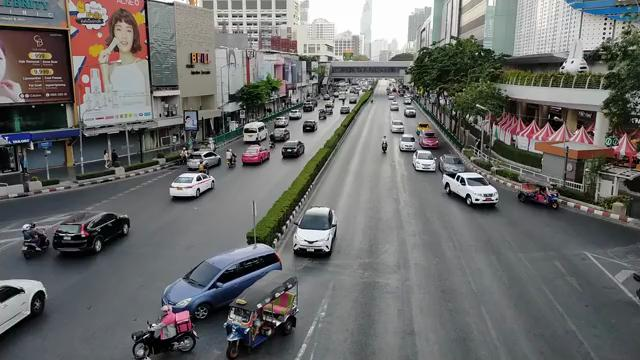
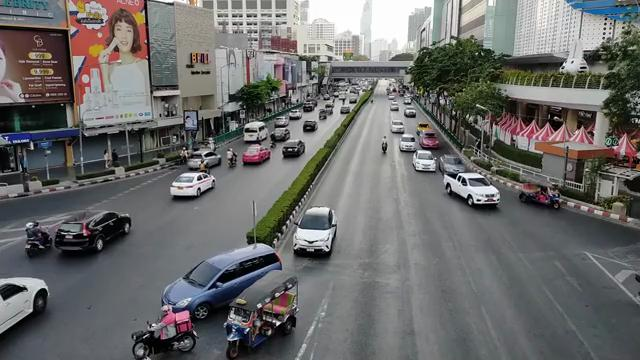
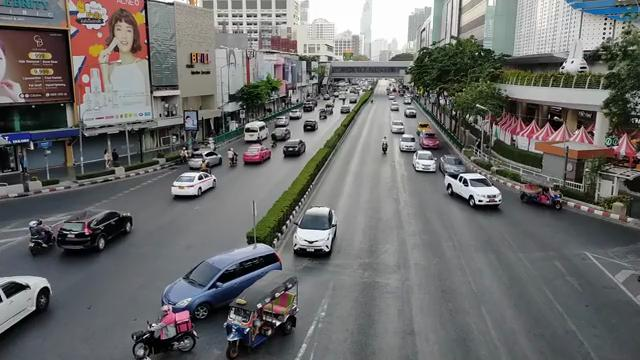

In [11]:
# Show the results of applying the `yolox_tiny` model to the first few frames in the table.

frames_view.select(frames_view.frame, yolox(frames_view.frame, model_id='yolox_tiny')).show(3)

It may appear that we just ran the YOLOX inference over the entire view of 462 frames, but remember that Pixeltable evaluates expressions lazily: in this case, it only ran inference over the 3 frames that we actually displayed.

The inference output looks like what we'd expect, so let's add a _computed column_ that runs inference over the entire view (we first encountered computed columns in the Pixeltable Basics tutorial). Remember that once a computed column is created, Pixeltable will update it incrementally any time new rows are added to the view. This is a convenient way to incorporate inference (and other operations) into data workflows.

In [10]:
# Create a computed column to compute detections using the `yolox_tiny` model.
# We'll adjust the confidence threshold down a bit (the default is 0.5) to pick up even more
# bounding boxes.

frames_view['detect_yolox_tiny'] = yolox(frames_view.frame, model_id='yolox_tiny', threshold=0.25)

Computing cells: 100%|████████████████████████████████████████| 462/462 [00:12<00:00, 37.22 cells/s]
Added 462 column values with 0 errors.


The new column is now part of the schema of the `frames` view:

In [12]:
frames_view

Column Name,Type,Computed With
pos,int,
frame_idx,int,
pos_msec,float,
pos_frame,float,
frame,image,
detect_yolox_tiny,json,"pixeltable.ext.functions.yolox.yolox(frame, model_id='yolox_tiny')"
video,video,


The data in the computed column is now stored for fast retrieval.

frame,detect_yolox_tiny
,"{'bboxes': [[338.1894836425781, 345.59979248046875, 433.25408935546875, 402.1943359375], [101.51329803466797, 419.788330078125, 259.7282409667969, 512.6688842773438], [-0.27876633405685425, 555.6809692382812, 96.86800384521484, 675.8363037109375], [478.0632629394531, 290.70819091796875, 541.0510864257812, 333.1060791015625], [317.3229064941406, 488.96636962890625, 571.7535400390625, 640.4901733398438], [561.7608032226562, 282.067138671875, 609.9308471679688, 318.03826904296875], [582.622802734375, 409.7627258300781, 675.9083862304688, 518.007568359375], [884.5014038085938, 341.38031005859375, 994.5653076171875, 413.2419128417969], [40.29541778564453, 447.2200622558594, 98.4399642944336, 512.966064453125], [261.9676513671875, 626.4561767578125, 395.9239807128906, 716.9423217773438], [483.1141357421875, 574.5985717773438, 597.1210327148438, 686.2103271484375], [881.5115356445312, 340.0090026855469, 997.948974609375, 415.1181945800781]], 'labels': [2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 7], 'scores': [0.8303581852689419, 0.8120178992683726, 0.7972358703894429, 0.7631068761987336, 0.7551505045317981, 0.6878083300243532, 0.6056828514921762, 0.5413047499647519, 0.5142479712737753, 0.502798736688618, 0.5010958015776623, 0.5003431232907474]}"
,"{'bboxes': [[338.1894836425781, 345.59979248046875, 433.25408935546875, 402.1943359375], [101.51329803466797, 419.788330078125, 259.7282409667969, 512.6688842773438], [-0.27876633405685425, 555.6809692382812, 96.86800384521484, 675.8363037109375], [478.0632629394531, 290.70819091796875, 541.0510864257812, 333.1060791015625], [317.3229064941406, 488.96636962890625, 571.7535400390625, 640.4901733398438], [561.7608032226562, 282.067138671875, 609.9308471679688, 318.03826904296875], [582.622802734375, 409.7627258300781, 675.9083862304688, 518.007568359375], [884.5014038085938, 341.38031005859375, 994.5653076171875, 413.2419128417969], [40.29541778564453, 447.2200622558594, 98.4399642944336, 512.966064453125], [261.9676513671875, 626.4561767578125, 395.9239807128906, 716.9423217773438], [483.1141357421875, 574.5985717773438, 597.1210327148438, 686.2103271484375], [881.5115356445312, 340.0090026855469, 997.948974609375, 415.1181945800781]], 'labels': [2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 7], 'scores': [0.8303581852689419, 0.8120178992683726, 0.7972358703894429, 0.7631068761987336, 0.7551505045317981, 0.6878083300243532, 0.6056828514921762, 0.5413047499647519, 0.5142479712737753, 0.502798736688618, 0.5010958015776623, 0.5003431232907474]}"
,"{'bboxes': [[338.1894836425781, 345.59979248046875, 433.25408935546875, 402.1943359375], [101.51329803466797, 419.788330078125, 259.7282409667969, 512.6688842773438], [-0.27876633405685425, 555.6809692382812, 96.86800384521484, 675.8363037109375], [478.0632629394531, 290.70819091796875, 541.0510864257812, 333.1060791015625], [317.3229064941406, 488.96636962890625, 571.7535400390625, 640.4901733398438], [561.7608032226562, 282.067138671875, 609.9308471679688, 318.03826904296875], [582.622802734375, 409.7627258300781, 675.9083862304688, 518.007568359375], [884.5014038085938, 341.38031005859375, 994.5653076171875, 413.2419128417969], [40.29541778564453, 447.2200622558594, 98.4399642944336, 512.966064453125], [261.9676513671875, 626.4561767578125, 395.9239807128906, 716.9423217773438], [483.1141357421875, 574.5985717773438, 597.1210327148438, 686.2103271484375], [881.5115356445312, 340.0090026855469, 997.948974609375, 415.1181945800781]], 'labels': [2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 7], 'scores': [0.8303581852689419, 0.8120178992683726, 0.7972358703894429, 0.7631068761987336, 0.7551505045317981, 0.6878083300243532, 0.6056828514921762, 0.5413047499647519, 0.5142479712737753, 0.502798736688618, 0.5010958015776623, 0.5003431232907474]}"

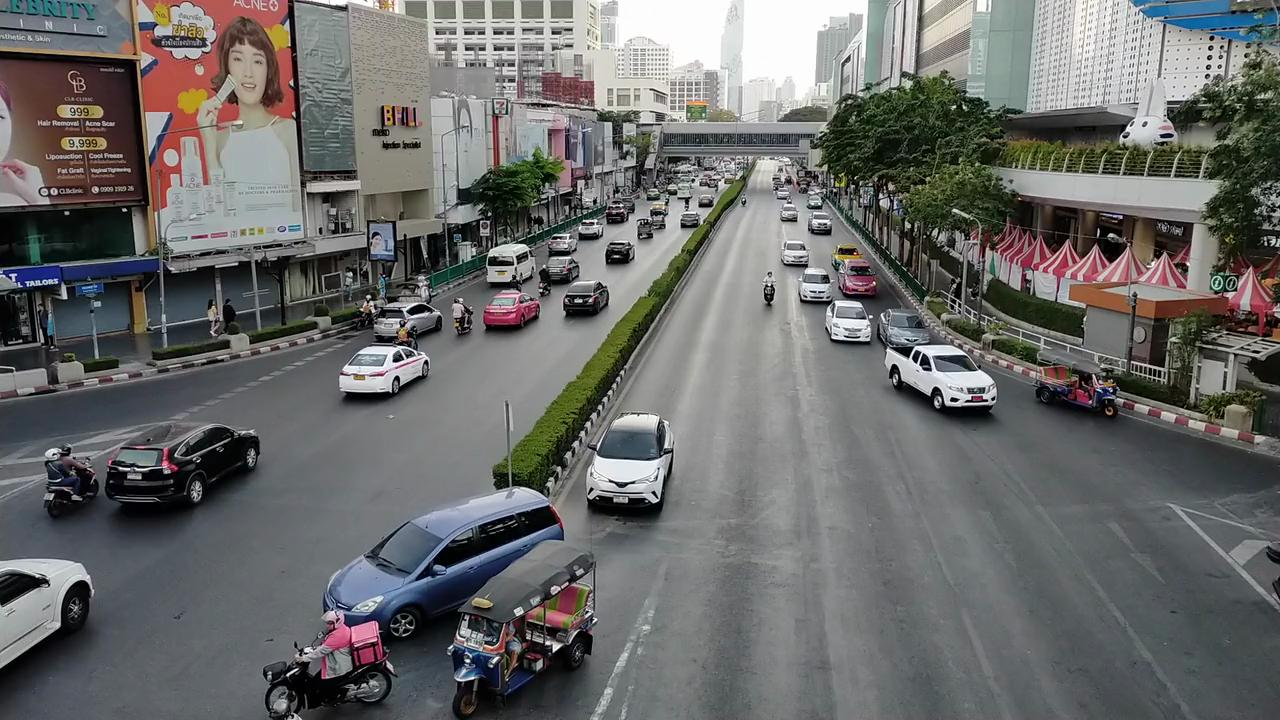
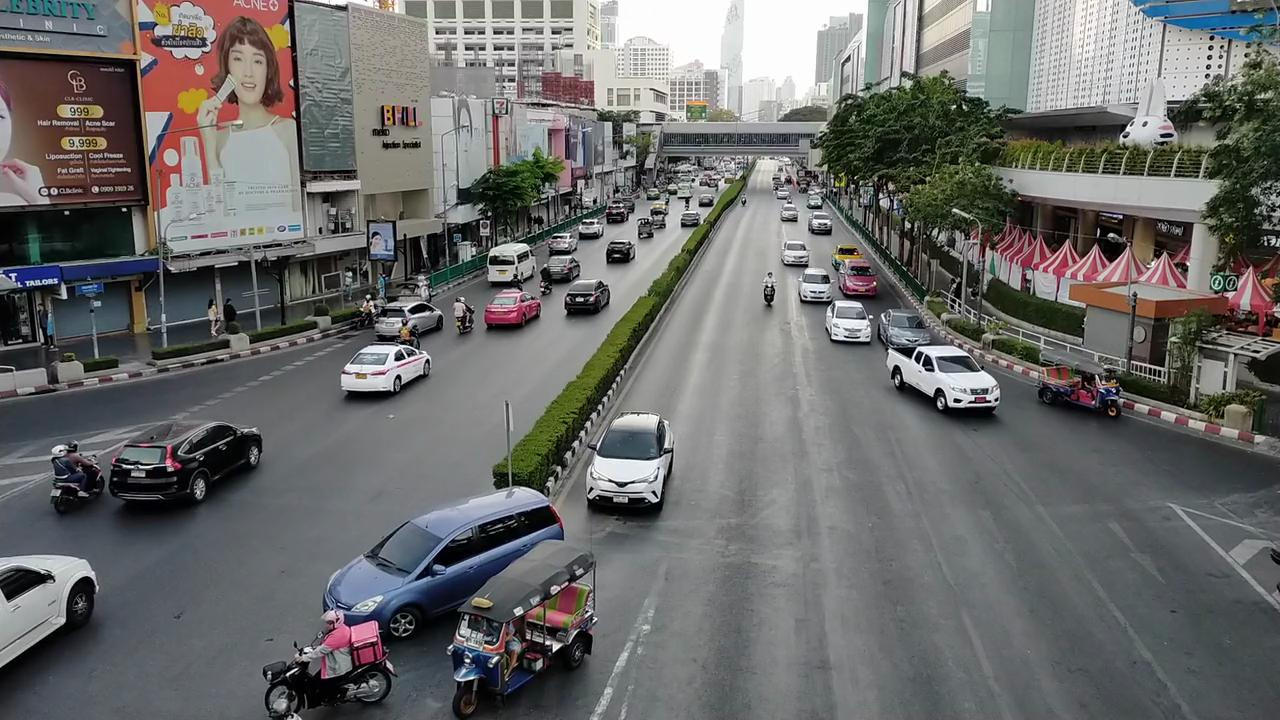
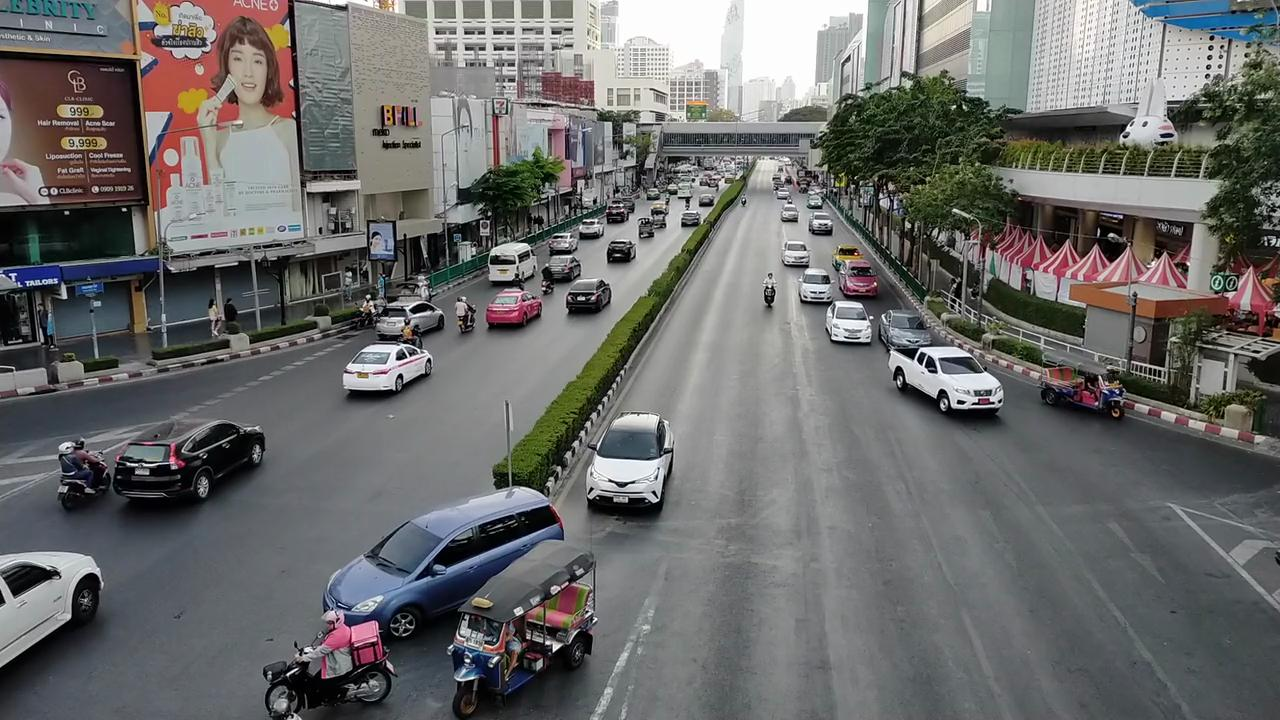

In [13]:
frames_view.select(frames_view.frame, frames_view.detect_yolox_tiny).show(3)

Now let's create a new set of images, in which we superimpose the detected bounding boxes on top of the original images. There's no built-in Pixeltable function to do this, but we can easily create our own. We'll use the `@pxt.udf` decorator for this, as we first saw in the Pixeltable Basics tutorial.

In [11]:
import PIL.Image
import PIL.ImageDraw

@pxt.udf
def draw_boxes(img: PIL.Image.Image, boxes: list[list[float]]) -> PIL.Image.Image:
    result = img.copy()  # Create a copy of `img`
    d = PIL.ImageDraw.Draw(result)
    for box in boxes:
        d.rectangle(box, width=3)  # Draw bounding box rectangles on the copied image
    return result

This function takes two arguments, `img` and `boxes`, and returns the new, annotated image. We could create a new computed column to hold the annotated images, but we don't have to; sometimes it's easier just to use a `select` comprehension, as we did when we were first experimenting with the detection model.

frame,col_1
,

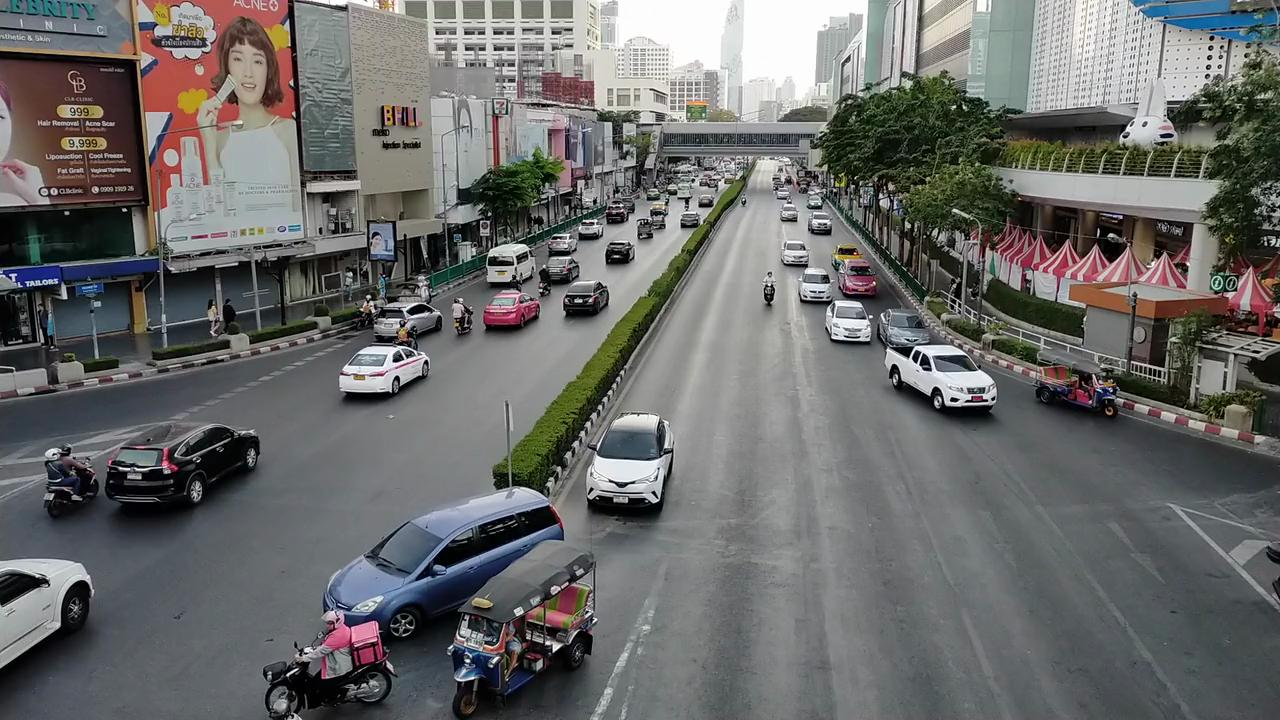
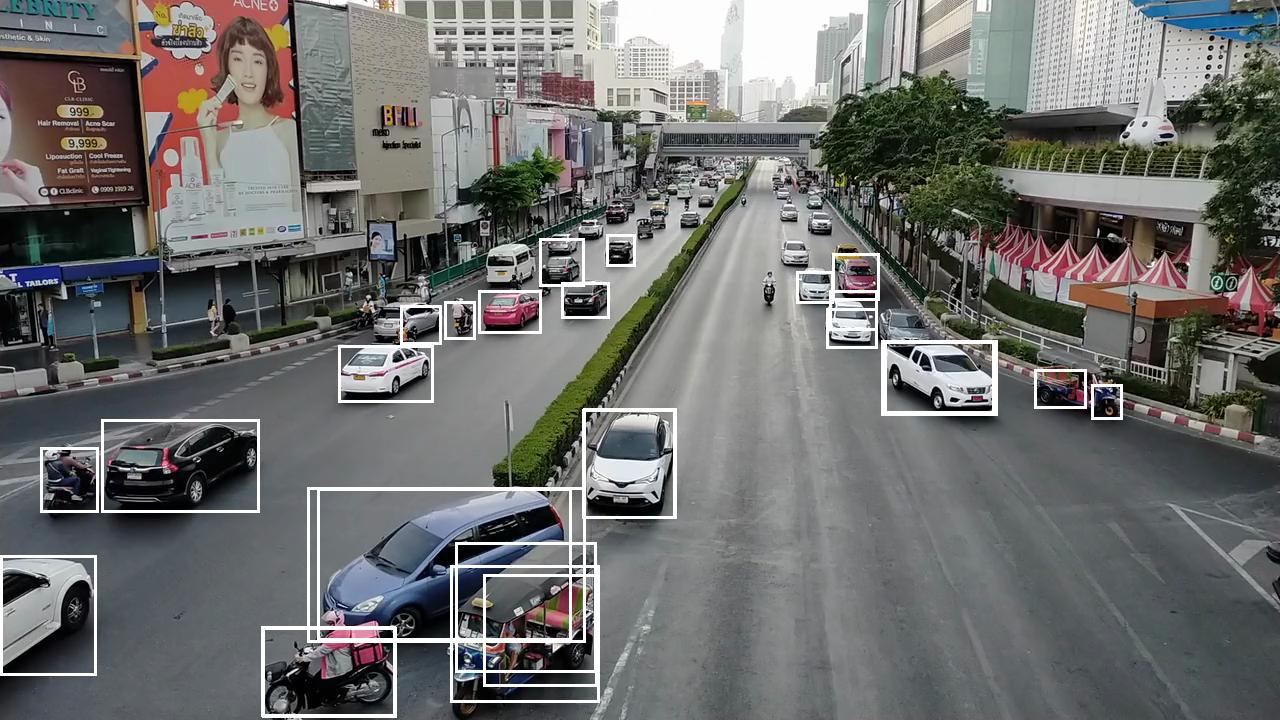

In [12]:
frames_view.select(frames_view.frame, draw_boxes(frames_view.frame, frames_view.detect_yolox_tiny.bboxes)).show(1)

Our `select` comprehension ranged over the entire table, but just as before, Pixeltable computes the output lazily: image operations are performed at retrieval time, so in this case, Pixeltable drew the annotations just for the one frame that we actually displayed.

Looking at individual frames gives us some idea of how well our detection algorithm works, but it would be more instructive to turn the visualization output back into a video.

We do that with the built-in function `make_video()`, which is an aggregation function that takes a frame index (actually: any expression that can be used to order the frames; a timestamp would also work) and an image, and then assembles the sequence of images into a video.

col_0
""

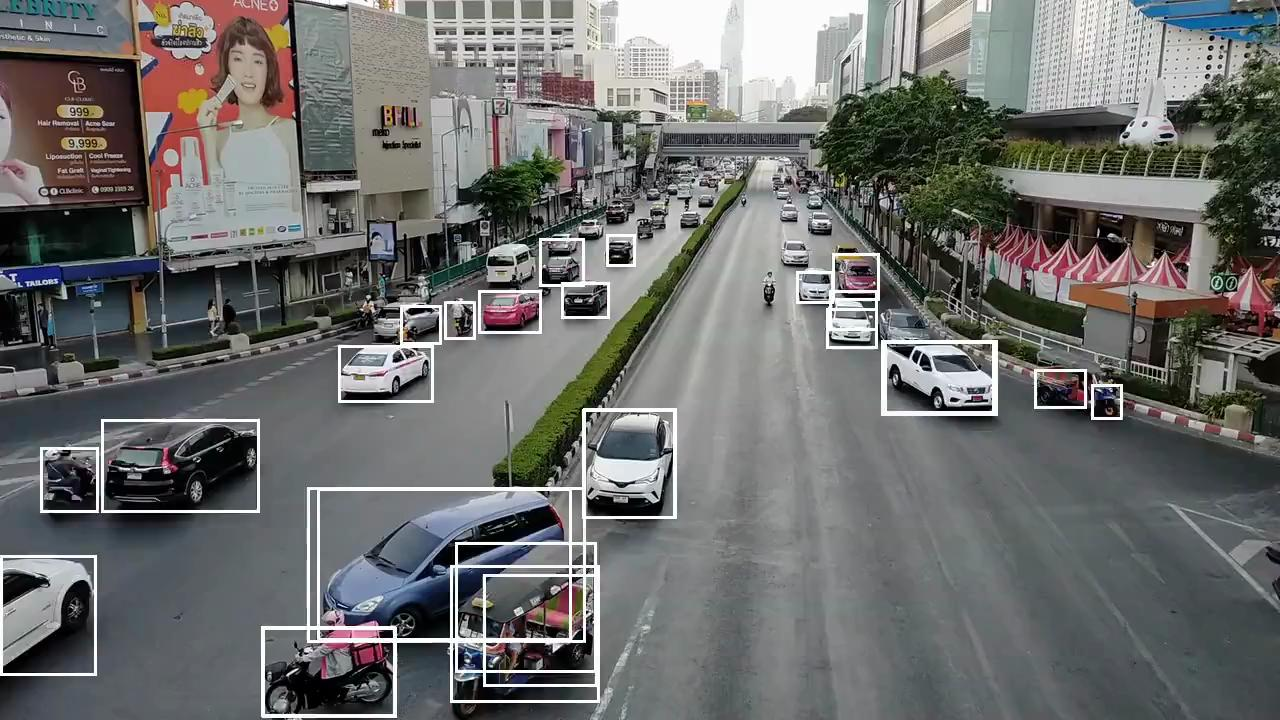

In [14]:
frames_view.select(pxt.functions.make_video(
    frames_view.pos, draw_boxes(frames_view.frame, frames_view.detect_yolox_tiny.bboxes)
)).group_by(videos_table).show(1)

## Comparing Object Detection Models

Now suppose we want to experiment with a more powerful object detection model, to see if there is any improvement in detection quality. We can create an additional column to hold the new inferences. The larger model takes longer to download and run, so please be patient.

In [15]:
# Here we use the larger `yolox_m` (medium) model.

frames_view['detect_yolox_m'] = yolox(frames_view.frame, model_id='yolox_m', threshold=0.25)

Computing cells: 100%|████████████████████████████████████████| 462/462 [01:20<00:00,  5.75 cells/s]
Added 462 column values with 0 errors.


Let's see the results of the two models side-by-side.

col_0,col_1
,

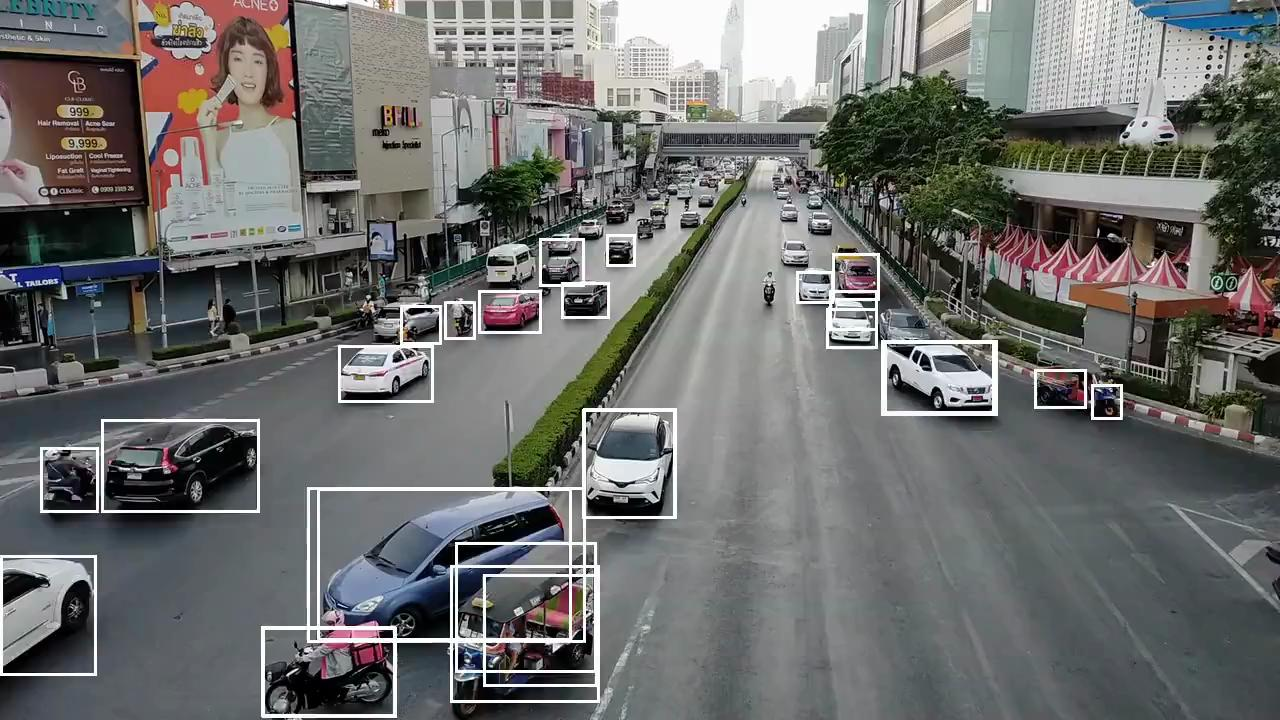
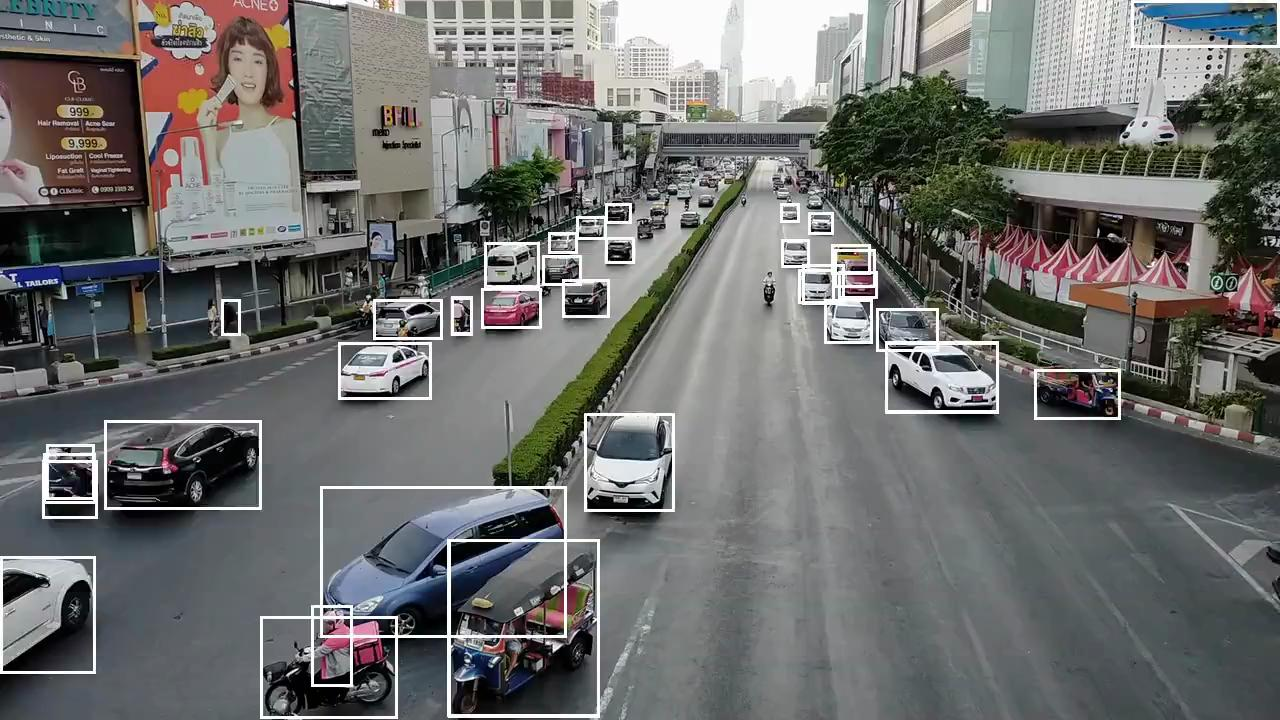

In [16]:
frames_view.select(pxt.functions.make_video(
    frames_view.pos, draw_boxes(frames_view.frame, frames_view.detect_yolox_tiny.bboxes)
), pxt.functions.make_video(
    frames_view.pos, draw_boxes(frames_view.frame, frames_view.detect_yolox_m.bboxes)
)).group_by(videos_table).show(1)

Running the videos side-by-side, we can see that the larger model is higher in quality: less flickering, with more stable boxes from frame to frame.

## Evaluating Models Against a Ground Truth

In order to do a quantitative evaluation of model performance, we need a ground truth to compare them against. Let's generate some (synthetic) "ground truth" data by running against the largest YOLOX model available. It will take even longer to cache and evaluate this model.

In [17]:
frames_view['detect_yolox_x'] = yolox(frames_view.frame, model_id='yolox_x', threshold=0.25)

Computing cells: 100%|████████████████████████████████████████| 462/462 [03:42<00:00,  2.08 cells/s]
Added 462 column values with 0 errors.


Let's have a look at our enlarged view, now with three `detect` columns.

In [18]:
frames_view

Column Name,Type,Computed With
pos,int,
frame_idx,int,
pos_msec,float,
pos_frame,float,
frame,image,
detect_yolox_tiny,json,"pixeltable.ext.functions.yolox.yolox(frame, model_id='yolox_tiny', threshold=0.25)"
detect_yolox_m,json,"pixeltable.ext.functions.yolox.yolox(frame, model_id='yolox_m', threshold=0.25)"
detect_yolox_x,json,"pixeltable.ext.functions.yolox.yolox(frame, model_id='yolox_x', threshold=0.25)"
video,video,


We're going to be evaluating the generated detections with the commonly-used [mean average precision](https://learnopencv.com/mean-average-precision-map-object-detection-model-evaluation-metric/) metric (mAP).

The mAP metric is based on per-frame metrics, such as true and false positives per detected class, which are then aggregated into a single (per-class) number. In Pixeltable, functionality is available via the `eval_detections()` and `mean_ap()` built-in functions.

In [23]:
from pixeltable.functions.eval import eval_detections, mean_ap

frames_view['eval_yolox_tiny'] = eval_detections(
    pred_bboxes=frames_view.detect_yolox_tiny.bboxes,
    pred_labels=frames_view.detect_yolox_tiny.labels,
    pred_scores=frames_view.detect_yolox_tiny.scores,
    gt_bboxes=frames_view.detect_yolox_x.bboxes,
    gt_labels=frames_view.detect_yolox_x.labels
)

frames_view['eval_yolox_m'] = eval_detections(
    pred_bboxes=frames_view.detect_yolox_m.bboxes,
    pred_labels=frames_view.detect_yolox_m.labels,
    pred_scores=frames_view.detect_yolox_m.scores,
    gt_bboxes=frames_view.detect_yolox_x.bboxes,
    gt_labels=frames_view.detect_yolox_x.labels
)

Computing cells: 100%|██████████████████████████████████████| 462/462 [00:00<00:00, 1368.53 cells/s]
Added 462 column values with 0 errors.
Computing cells: 100%|██████████████████████████████████████| 462/462 [00:00<00:00, 1107.99 cells/s]
Added 462 column values with 0 errors.


Let's take a look at the output.

In [24]:
frames_view.select(frames_view.eval_yolox_tiny, frames_view.eval_yolox_m).show(1)

eval_yolox_tiny,eval_yolox_m
"[{'fp': [0], 'tp': [1], 'class': 0, 'scores': [0.2907288888372772], 'min_iou': 0.5, 'num_gts': 2}, {'fp': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1], 'tp': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0], 'class': 2, 'scores': [0.7872271605747017, 0.7502694030727497, 0.715124681105511, 0.6936472439401662, 0.683785547057969, 0.677372470130905, 0.6698970090013034, 0.62884452848742, 0.5871905254114651, 0.5710168437431093, 0.5488205668580015, 0.5259768317254299, 0.48887483737519943, 0.47543792124952233, 0.46769257760649907, 0.38620557516102494, 0.38372188358909654, 0.317142701160833, 0.2877547688975284, 0.26306287613733303, 0.25544114758308467], 'min_iou': 0.5, 'num_gts': 26}, {'fp': [0], 'tp': [1], 'class': 3, 'scores': [0.4318316368752022], 'min_iou': 0.5, 'num_gts': 2}, {'fp': [1, 1, 1, 1], 'tp': [0, 0, 0, 0], 'class': 7, 'scores': [0.4326881584858082, 0.40418366308550446, 0.3343880252577094, 0.3004307208460677], 'min_iou': 0.5, 'num_gts': 3}, {'fp': [], 'tp': [], 'class': 62, 'scores': [], 'min_iou': 0.5, 'num_gts': 1}]","[{'fp': [0, 0], 'tp': [1, 1], 'class': 0, 'scores': [0.5906626362366296, 0.4197695328015243], 'min_iou': 0.5, 'num_gts': 2}, {'fp': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'tp': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'class': 2, 'scores': [0.9377970087823826, 0.9109554748064141, 0.908164867060627, 0.9079046285636494, 0.9055690307724795, 0.8989922094856766, 0.8858143924749129, 0.8350089570296824, 0.8276892640623146, 0.81195466107717, 0.793378401471017, 0.7883692953281667, 0.7825780104827516, 0.726172586179544, 0.6596614990491219, 0.602790688246376, 0.5862725982668522, 0.5607722286454866, 0.5137047251223414, 0.49374396448845914, 0.4520889082124313, 0.3697712154653967, 0.2638622064315239], 'min_iou': 0.5, 'num_gts': 26}, {'fp': [0, 0, 1, 1], 'tp': [1, 1, 0, 0], 'class': 3, 'scores': [0.8785447149359911, 0.6549525857618264, 0.44053755214768486, 0.3977024902988049], 'min_iou': 0.5, 'num_gts': 2}, {'fp': [0, 0], 'tp': [1, 1], 'class': 7, 'scores': [0.47758490860690017, 0.4115085451228673], 'min_iou': 0.5, 'num_gts': 3}, {'fp': [], 'tp': [], 'class': 62, 'scores': [], 'min_iou': 0.5, 'num_gts': 1}]"


The computation of the mAP metric is now simply a query over the evaluation output, aggregated with the `mean_ap()` function.

In [26]:
frames_view.select(mean_ap(frames_view.eval_yolox_tiny), mean_ap(frames_view.eval_yolox_m)).show()

col_0,col_1
"{0: 0.10811645671868587, 2: 0.6227539708588857, 3: 0.27753975947335474, 7: 0.09323260954335098, 62: 0.0, 58: 0.0, 9: 0.0, 5: 0.02960526315789474, 8: 0.0, 1: 0.0}","{0: 0.5944106052226086, 2: 0.9121062275615797, 3: 0.7225004856681095, 7: 0.5251759030270571, 62: 0.0, 4: 0.0, 58: 0.041590214067278294, 1: 0.0, 5: 0.6499999999999999}"


This two-step process allows you to compute mAP at every granularity: over your entire dataset, only for specific videos, only for videos that pass a certain filter, etc. Moreover, you can compute this metric any time, not just during training, and use it to guide your understanding of your dataset and how it affects the quality of your models.